# 3. K-Means Kümeleme Ödevi (dava.csv)

#### → Kütüphaneler içeri aktarıldı.

import KMeans :  KMeans kümeleme algoritması için

import StandardScaler :  Veriyi standartlandırmak için

import PCA : Çok sayıda özelliği az sayıda ana bileşene indirmek için

import silhouette_score, silhouette_samples : Kümelemenin kalitesini ölçmek için

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore') # Gereksiz uyarıları gizlemek için

#### → dava.csv dosyası DataFrame'e yüklendi.

In [53]:
data = pd.read_csv('dava.csv')
print(data.head())
print(f"Veri seti boyutu: {data.shape}")

   Unnamed: 0  Case Duration (Days)  Number of Witnesses  Legal Fees (USD)  \
0           0                   132                    8             35206   
1           1                   300                   12             46106   
2           2                   136                    2             16411   
3           3                   101                    1              7911   
4           4                   218                   16              6734   

   Number of Evidence Items  Severity  Outcome  
0                        49         2        0  
1                        46         2        1  
2                        31         1        1  
3                        35         1        0  
4                        33         1        0  
Veri seti boyutu: (100, 7)


#### → Eksik değer kontrolü yapıldı.

In [54]:
print(f"\nEksik değer kontrolü:")
print(data.isnull().sum())


Eksik değer kontrolü:
Unnamed: 0                  0
Case Duration (Days)        0
Number of Witnesses         0
Legal Fees (USD)            0
Number of Evidence Items    0
Severity                    0
Outcome                     0
dtype: int64


## Görev 1 : Kümeleme İçin Uygun Özellikleri Seçme

Severity ve Outcome özellikleri, ordinal (sıralı) kategorik değişken olduğu için sayısal özellikler seçiminde yer almadı.

In [55]:
sayisal_ozellikler = ['Case Duration (Days)', 'Number of Witnesses',
                      'Legal Fees (USD)', 'Number of Evidence Items']
print(f"Kümeleme için seçilen özellikler: {sayisal_ozellikler}")

kumeleme = data[sayisal_ozellikler].copy()
print(f"Kümeleme veri seti boyutu: {kumeleme.shape}")

Kümeleme için seçilen özellikler: ['Case Duration (Days)', 'Number of Witnesses', 'Legal Fees (USD)', 'Number of Evidence Items']
Kümeleme veri seti boyutu: (100, 4)


##### → StandartScaler ile veriler aynı ölçeğe getirildi.

In [8]:
skaler = StandardScaler()
kumeleme_standart = skaler.fit_transform(kumeleme)
print("Veriler StandardScaler ile ölçeklendirildi.")

Veriler StandardScaler ile ölçeklendirildi.


## Görev 2 : Elbow Yöntemi ile Optimal Küme Sayısını Belirleme

K-Means algoritmasında en kritik soru: Veriyi kaç kümeye ayırmalıyım?

Çok az küme → Detay kaybı
Çok fazla küme → Aşırı detay

#### → WCSS (Within-Cluster Sum of Squares) - Elbow Method
Her noktanın kendi küme merkezine olan uzaklıklarının karelerinin toplamıdır.
Düşük WCSS = İyi kümelenme (noktalar merkezlere yakın)

WCSS = Σ (her kümedeki her nokta için) (nokta - merkez)²

→ Elbow (Dirsek) Noktası:
WCSS'nin en hızlı düştüğü noktadır. Grafikte dirsek şeklinde kıvrım oluşur. O noktadan sonra fazla iyileşme olmaz.

n_clusters=k: Bu iterasyonda k tane küme oluşturma

random_state=42:  Tekrarlanabilir sonuçlar için sabit rastgelelik

n_init=10: 10 farklı başlangıç noktası deneyip en iyisini seçme

→ K-Means başlangıç noktalarına duyarlıdır, birden fazla deneme yaparak en iyi sonucu bulur.

kmeans.fit(X_scaled): Modeli eğiitme

kmeans.inertia_: WCSS değerini alma

In [56]:
kume_range = range(2, 11)  # minimum anlamlı küme sayısı 2'dir.
wcss = []
for k in kume_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(kumeleme_standart)
    wcss.append(kmeans.inertia_)

En büyük düşüşten sonraki noktayı bulmaya çalıştığımız için 1'den başlandı, WCSS'ler arası fark hesaplanırken index 1 azaldı. Sonuç olarak 2 indexlik fark +2 şeklinde eklendi. +1 (np.diff kayması)  +  +1 ([1:] kayması)  =  +2

In [58]:
wcss_fark= np.diff(wcss)
elbow_k = kume_range[np.argmin(wcss_fark[1:]) + 2]

#### → Elbow method önerisi ile optimal küme sayısını bulma

In [59]:
wcss_df = pd.DataFrame({
    'K': kume_range,
    'WCSS': wcss })
print(wcss_df)
print(f"Elbow method önerisi: k={elbow_k}")

    K        WCSS
0   2  315.142440
1   3  257.798116
2   4  215.314899
3   5  182.081344
4   6  164.551839
5   7  143.967886
6   8  131.322278
7   9  116.551766
8  10  106.391274
Elbow method önerisi: k=4


## Görev 3 : K-Means Algoritması ile Veriyi Kümeleme

#### K-Means Algoritmasının Çalışma Prensibi
1.Başlangıç: k tane rastgele merkez noktası seçilmesi.

2.Atama: Her noktayı en yakın merkeze atama.

3.Güncelleme: Her kümenin yeni merkezini hesaplama (ortalama)

4.Tekrarlama: Merkezler değişmeyene kadar tekrarlama.

In [60]:
optimal_k = elbow_k  # Silhouette'e göre en iyi k
print(f"Seçilen küme sayısı: {optimal_k}")

Seçilen küme sayısı: 4


In [61]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(kumeleme_standart)
kume_kmeans = kmeans_final.predict(kumeleme_standart)

#### → DataFrame'de Görme

In [62]:
data_kumeli = data.copy()
data_kumeli['Kümelenme'] = kume_kmeans
print(data_kumeli.head())

   Unnamed: 0  Case Duration (Days)  Number of Witnesses  Legal Fees (USD)  \
0           0                   132                    8             35206   
1           1                   300                   12             46106   
2           2                   136                    2             16411   
3           3                   101                    1              7911   
4           4                   218                   16              6734   

   Number of Evidence Items  Severity  Outcome  Kümelenme  
0                        49         2        0          3  
1                        46         2        1          3  
2                        31         1        1          1  
3                        35         1        0          1  
4                        33         1        0          2  


#### → Kümelerin Elemanlarını Saydırma

In [63]:
kume_sayisi = pd.Series(kume_kmeans).value_counts().sort_index()
print(kume_sayisi)

0    19
1    23
2    28
3    30
Name: count, dtype: int64


## Görev 4 : Kümelemeyi Grafiklerle Görselleştirme

#### Elbow Grafiği

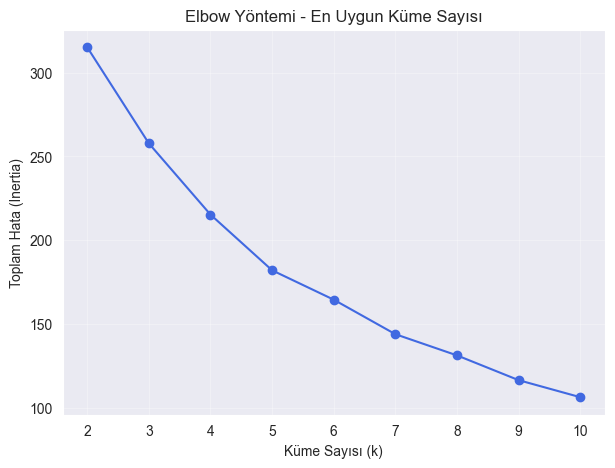

In [64]:
plt.figure(figsize=(7, 5))
plt.plot(range(2, 11), wcss, marker='o', color='royalblue')
plt.title("Elbow Yöntemi - En Uygun Küme Sayısı")
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Toplam Hata (Inertia)")
plt.grid(True, alpha=0.3)
plt.show()

#### K-Means Kümeleri Görselleştirme ( Dava süresi ve Hukuk Masrafı)

Renkler = Kümeler (Küme 0, Küme 1, Küme 2, Küme 3)

Sarı X işaretleri = Küme merkezleri (ortalama noktalar)

1.Küme 0 (Kırmızı)

   * Dava süresi kısa
   * Masraflar yüksek

2.Küme 1 (Yeşil)

   * Dava süresi uzun
   * Masraflar düşük


3.Küme 2 (Mavi)

   * Dava süresi orta–uzun
   * Masraflar genelde düşük–orta

4.Küme 3 (Mor)

   * Dava süresi çok değişken
   * Masraflar en yüksek
   * Pahalı ve uzun davalar

 Yorumlama : Dava süresi ile masraf arasında her zaman pozitif bir ilişki yoktur; bazı uzun davalar görece ucuz olabilmektedir.



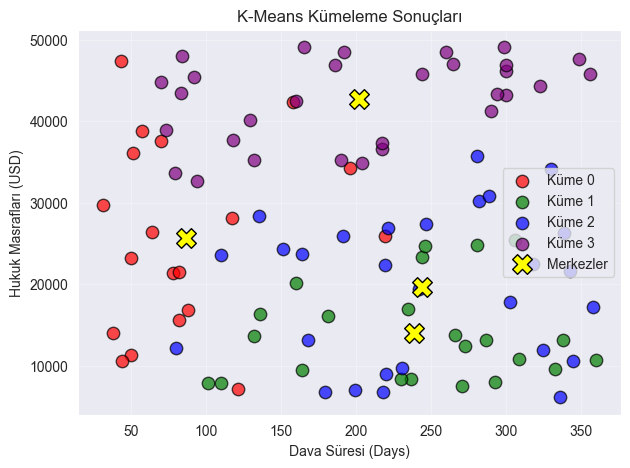

In [48]:
plt.figure(figsize=(7, 5))
colors = ['red', 'green', 'blue', 'purple', 'orange']

for i in range(optimal_k):
    mask = (data_kumeli['Kümelenme'] == i)
    plt.scatter(data_kumeli.loc[mask, 'Case Duration (Days)'],
                data_kumeli.loc[mask, 'Legal Fees (USD)'],
                color=colors[i],
                label=f'Küme {i}',
                alpha=0.7,
                s=80,
                edgecolors='black')

merkezler = skaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(merkezler[:, 0], merkezler[:, 2],  # 0: süre, 2: masraf (Legal Fees)
            color='yellow', marker='X', s=200, edgecolors='black', label='Merkezler')

plt.title("K-Means Kümeleme Sonuçları", fontsize=12)
plt.xlabel("Dava Süresi (Days)")
plt.ylabel("Hukuk Masrafları (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



#### Değişkenler Arası Korelasyon Matrisi

+1’e yakın değer: güçlü pozitif ilişki 

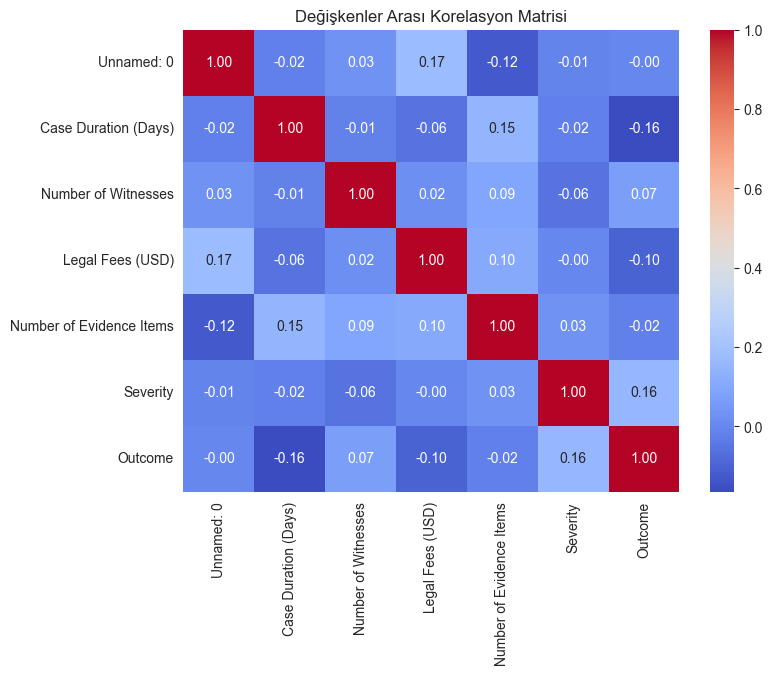

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Değişkenler Arası Korelasyon Matrisi")
plt.show()


#### Küme Boyutlarını Gösterme

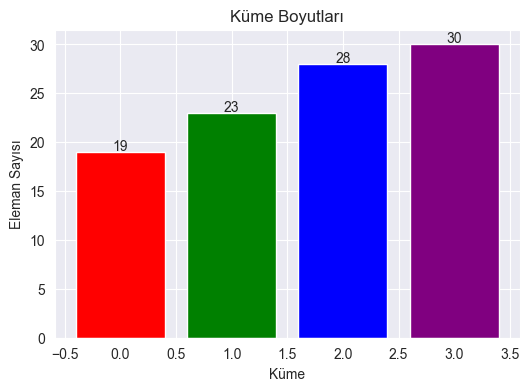

In [51]:
import pandas as pd

kume_sayisi = pd.Series(kume_kmeans).value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(kume_sayisi.index, kume_sayisi.values, color=colors[:optimal_k])
plt.title("Küme Boyutları", fontsize=12)
plt.xlabel("Küme")
plt.ylabel("Eleman Sayısı")

for i, count in enumerate(kume_sayisi.values):
    plt.text(i, count + 0.2, str(count), ha='center')

plt.show()
